# Exercise Lecture 14: Neural Classification


In this set of exercises, we will use a Recurrent Neural Network to classify BBC news articles into 5 topics. The dataset consists of 2225 documents and 5 categories: business, entertainment, politics, sport, and technology. 


The exercises cover the following points:

* Converting the text in the corpus to vectors of integers (each integer represents a word in the corpus vocabulary)
* Computing some descriptive statistics to identify a sentence length cutoff (sentences with longer lengths will not be considered for training)
* Specifying, training and testing a recurrent neural network 

# Preprocessing (PROVIDED)

We first prepocessed the data to extract X (the input) and Y (the input labels)

In [3]:
import pandas as pd
import numpy as np 
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.datasets import load_files

# for reproducibility
random_state = 0 

DATA_DIR = "bbc"
data = load_files(DATA_DIR, encoding="utf-8", decode_error="replace", random_state=random_state)


df = pd.DataFrame({'news_report': data['data'], 'labels': data['target']})
df.head()

,news_report,labels
0,Tate & Lyle boss bags top award\n\nTate & Lyle...,0
1,Halo 2 sells five million copies\n\nMicrosoft ...,4
2,MSPs hear renewed climate warning\n\nClimate c...,2
3,Pavey focuses on indoor success\n\nJo Pavey wi...,3
4,Tories reject rethink on axed MP\n\nSacked MP ...,2


Extracting X (texts) and Y (classes)

In [1]:
cd ..

C:\experiments\cours nlp\data science\lecture14


In [4]:
texts = df["news_report"].str.lower()
labels = df["labels"]

print(texts[12])
print(labels[12])

sport betting rules in spotlight

a group of mps and peers has called for a tightening of regulations controlling betting on sport.

the parliamentary group on betting and gaming held a substantial inquiry into betting last year. it followed fears that a massive increase in betting on sport, such as that done using the internet and mobile phones, has led to more cheating. the all-party group recommended 15 ways to protect punters and improve the integrity of sports betting. they include a proposal for raising the maximum jail sentence for gambling cheats above the current two years. lord condon, head of the international cricket council's anti-corruption unit, who originally made the call for longer prison sentences, said the two-year penalty was "derisory". "you could get a bigger sentence for failing to pay your hotel bill criminally than you could for corruption in major sports. "symbolically, a higher penalty, perhaps as the bill passes through the two houses, might be appropriate.

# Converting the texts in the corpus to vectors of integers 

#### Exercise 1 -  Convert the corpus to a list of lists of integers

* Define a dictionary tokens2int which maps each distinct token in the corpus to a distinct integer 
( the size of this dictionary is the size of the corpus vocabulary i.e., the number of distinct tokens in the corpus, cf. Python CS)
* Use this dictionary to map each news report to a vector.


**Example**
* Input Texts: ["The woman put the book on the table","The woman reads"]
* Created vocabulary: {the, woman, put, book, on, table, reads}
* Output Texts: [ [1,2,3,1,4,5,1,6], [1,2,7]]



In [5]:
from collections import defaultdict
import nltk
from nltk.tokenize import word_tokenize
all_vocab = []
token2int = defaultdict(lambda: len(token2int)) #can we use enumerate to do that? 
token2int['<eos>'] = 0
for text in texts:
    tokens = word_tokenize(text)
    token_ids = []
    
    for token in tokens:
        token_ids.append(token2int[token.lower()])
        
    all_vocab.append(token_ids)

# Compréhension de liste
token2int = defaultdict(lambda: len(token2int)) 
all_vocab = [[token2int[token.lower()] for token in nltk.word_tokenize(text)] for text in texts]

In [22]:
int_text = []
for l in texts:
    tmp_list = []
    for i in l.split():
        tmp_list.append(token2int[i])
    int_text.append(tmp_list)

In [ ]:
all_vocab

#### Exercise 2 - Define the reverse int2token mapping and check the token2int and the int2token mappings on an example

* Check that the words have been correctly converted to integer by applying the reverse integer to token mapping
* Print out the vocabulary size
* Print out the maximum text length


In [7]:
int2token = {v: k for k, v in token2int.items()}

In [10]:
print(max([len(l) for l in int_text]))

4432


#### Exercise 3 - Compute some statistics to determine which sentences to keep

The maximum sentence size is very large (4432 tokens). Presumably most reports are not that long. Use pandas describe() method and matplotlib to get a better idea of the data distribution in terms of report length.

* Compute the list of report lengths (list of nb of tokens for each report in the BBC news corpus)
* Compute the box plots for report lengths
* Use pandas desribe() method to get the descripte statistics (min, max, means, etc.)

In [8]:
df['nb_token'] = df['news_report'].apply(lambda x : len(x.split()))

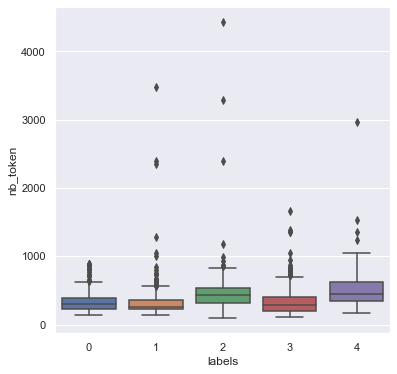

In [9]:
import seaborn as sns
plt.figure(figsize=(6, 6))
sns.set_theme()
sns.boxplot(x = "labels", y = "nb_token", data = df);

In [10]:
df['nb_token'].describe()

count    2225.000000
mean      384.040449
std       238.174497
min        89.000000
25%       246.000000
50%       332.000000
75%       471.000000
max      4432.000000
Name: nb_token, dtype: float64

# 2  Classifying with a Recurrent Neural Network

We import some pytorch submodules

* torch: functions to create tensors and operations on tensors 
* torch.nn: to specify neural networks
* torch.nn.functional for when we want to define a custom layer for example with a convolution operation layer.
* torch.optim: optimizers for training 

We also need to specify some constants which ensure that the code can run on CPU. The `max_len` constant is important as text whose size exceeds (in number of tokens) that limit will be discarded. We set it to 471. 

In [11]:
# conda install pytorch-cpu torchvision-cpu -c pytorch

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Exercise 4 - Creating tensors

To help speed up computation, all data must be converted to tensors. 

* Set the maximum size of text to the 3rd quartile (471)
* Create a tensor of size  (number of texts, maximum size of a text) for X. Call this tensor X. Longer texts will be cut down to maximal size and shorter texts will be padded with `<eos>`. Use torch.zeros method and make sure to specify the components will be of type integer (long attribute in torch)
* Populate this matrix with the integer version of the BBC news report (cf. Exercise 1). Use the torch.LongTensor method. When populating the matrix cut down sentence whose length is above the max length to max length
* Create another tensor of size (numbers of text) and populate it with the list of labels. Call this tensor Y.
* Print out the shape of X and Y . X should be of size (2225, 471) and Y of size (2225,) 

N.B. In practice, it is not necessary to have all the data in a single tensor. In fact, this is inefficient if the texts have varied length. The only constraint is that for a given batch, all sequences have the same size. 

In [13]:
max_size = 471
pad_text = []
for l in all_vocab:
    if len(l)>= max_size:
        pad_text.append(l[:max_size+1])
    else:
        pad_text.append(l[:len(l)+1] + (max_size - len(l))*[0])

471

471

#### Exercise 5 - Create train and test data

* Split X into two parts, one called X_train which consists of the first 1112 items and the other called X_valid which includes the rest of the data
* Do the same for Y

#### Create batches (PROVIDED)

pytorch provides a batch generator which shuffles the data. We apply it to train and validation data

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
# the TensorDataset is a ready to use class to represent your data as list of tensors. 
# Note that input_features and labels must match on the length of the first dimension
train_set = TensorDataset(X_train, Y_train)
valid_set = TensorDataset(X_valid, Y_valid)

# DataLoader shuffles and batches the data and load its in parallel using multiprocessing workers

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

#### Exercise 6 - Define your neural network

We define a network by specifying a subclass of the appropriate pytorch modules. For instance here, as we want to create an RNN we create a subclass of pytorch RNN module. The specification of the network falls into 2 parts. 

In the init part, the layers of the network are defined and  their type and shape are specified.  

In the forward part, we connect the layers and specify input and output for each layer. 
 
* The hidden state returned by the GRU layer is of size (num_layers * num_directions, batch_size, hidden_size) 
* The input to the decision layer should be of size (batch_size, hidden_size).   

Hence the first 2 dimensions of hidden must be transposed and the tensor redimensioned to (batch_size, hidden_size).

* drop : (num_layers * num_directions, batch_size, hidden_size)
* drop.transpose(0,1): (batch_size, num_layers * num_directions,  hidden_size)
* x.size(0) = batch_size
* drop.transpose(0,1).contiguous.view(x.size(0), -1): (batchsize, hiddensize)

**TODO:** fill in the missing variables (marked by ???)

In [ ]:
class RNN(nn.Module):
  
        
    def __init__(self):
        super().__init__()
        
        # Here we define the network layers
        
        # An embedding layer projecting vectors of size vocab_size into embeddings of size embed_size
        # Assigns to each word in the vocabulary an embedding of size embed_size
        self.embed = nn.Embedding(???, embed_size)
        
        # A recurrent (GRU) layer to process each input token (represented by its embedding)
        # The GRU network takes as input the embedding (of size embed_size) of the current word 
        # and the previous hidden state (of size hidden_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers=1, bidirectional=False, batch_first=True)
        
        # Drop out layer for regularisation
        self.dropout = nn.Dropout(0.3)
        
        # Fully connected layer mapping 
        # the last layer maps a hidden state to a vector of size the number of classes
        self.decision = nn.Linear(hidden_size, ???)
         
    def forward(self, x):
        # Here we say how the layers are connected 
       
        #  for each token in the input, retrieve the corresponding embeddings 
        
        # x = [batch size, input size]
        embed = self.embed(x)
        # embed = [batch size, sent len, emb dim]       
       
        # Run the RNN on the input embeddings
        # output is the sequence of hidden states produced by the RNN
        # hidden is the last hidden state produced
        output, hidden = self.rnn(???)
        
        # output = [sent len, batch size, hidden size]
        # hidden = [num_layers * num_directions, batch size, hidden_size ]
        
        # Apply dropout (for regularisation)
        drop = self.dropout(hidden)
        
        # drop = [num_layers * num_directions, batch size, hidden_size]   
        
        # Apply the fully connected layer to the output of the dropout
        # Expected input size: [batch_size, input_size]
        # We transpose [num_layers * num_directions, batch size, hidden_size ]
        # to: [batch size, num_layers * num_directions, hidden_size ]
        # And apply view to create an input of the form [batch size, input_size ]
        # (x.size(0) = batch size)
        return self.decision(drop.transpose(0, 1).view(x.size(0), -1))
    
rnn_model = RNN()
rnn_model.to(device)

#### Exercise 7  - Evaluating 

We define an evaluation fonction (called "perf") which computes the average loss on the test/validation dataset and the proportion of correct cases. 

* We use pytorch nn.CrossEntropyLoss() as loss function.
* For each batch returned by the loader, we calculate the scores produced by the model for each class, the loss, the predictions and the loss.
* To block dropout (which should only be used at training time), we use the eval() method. 
* "with torch.no_grad()" temporarily set all the requires_grad flag to false. In practice, this enforces that gradients are not computed (and therefore the weights of the model remain unchanged). 

**TODO:** Modify the function so that it outputs the proportion of correct predictions in addition to the loss


In [1]:
def perf(model, loader):
    # define the loss
    criterion = nn.CrossEntropyLoss()
    # No drop out
    model.eval()
    total_loss = correct = num = 0
    for x, y in loader:
    # No gradient computation, weights remain unchanged
      with torch.no_grad():
        # Compute the scores for the instances in the input batch
        y_scores = model(x)
        # Compute the loss
        loss = criterion(y_scores, y)
        # Compute the predictions
        y_pred = torch.max(y_scores, 1)[1]
        # Update the batch loss
        total_loss += loss.item()
        num += len(y)
    return total_loss / num

#### Exercise 8  - Training Loop

Define a function fit(model, epochs) which you will use to train your model

* use the CrossEntropyLoss and the Adam optimizer
* iterates over the epochs and for each epoch:
   - Set the module in training mode (use the train() method). Drop out will apply and gradients will be computed. 
   - Initialise the total loss to 0
   - Iterate over each batches returned by train_loader    
     For each batch:   
        - set the gradients to null (optimizer.zero_grad())
        - predicts the batch scores
        - calculate the loss
        - back propagate
        - optimize (adjust the weights)
        - update the total loss
   - print out the average loss on the training data and on the validation data as well as the proportion of correct cases on the validation data (use the perf function defined in the preceding exercise).
   
**Hint:** Some of these steps are defined in the preceding exercise.

#### Exercise 9 - Training

Use the fit function you just defined to train your model. 
* The loss function on the train and validation set should decrease
* The accuracy on the validation set should improve

### CNN Model

Here below is a CNN model definition. Run it on the data and compare the speed and results with that of the RNN.

In [ ]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Embedding(len(vocab), embed_size)
        self.conv = nn.Conv1d(embed_size, hidden_size, kernel_size=2)
        self.dropout = nn.Dropout(.3)
        self.decision = nn.Linear(hidden_size, len(set(labels)))

    def forward(self, x):
        embed = self.embed(x)
        conv = F.relu(self.conv(embed.transpose(1,2)))
        pool = F.max_pool1d(conv, conv.size(2))
        drop = self.dropout(pool)
        return self.decision(drop.view(x.size(0), -1))

cnn_model = CNN()
cnn_model.to(device)